In [156]:
'''
For exploring the valA.h5 dataset to ensure that our data is
formatted similarly. Compares the valA.h5 dataset against the dataset we generate
and extracts object and image data from our dataset.
Author: Noah Ponto
'''

'\nCode document for exploring the valA.h5 dataset to ensure that our data is\nformatted similarly. Compares the valA.h5 dataset against the dataset we generate\nand extracts object and image data from our dataset.\n'

In [157]:
import h5py
import numpy as np
example_path = '../../valA.h5'
my_path = '../output/h5outputfile.h5'
example_hf = h5py.File(example_path, 'r')
my_hf = h5py.File(my_path, 'r')
example_scene_key = list(example_hf.keys())[0]
print(f'First scene {example_scene_key}')
# Assert the first key of both is '000000'
assert(list(my_hf.keys())[0] == example_scene_key)
print('scene name matches')



First scene 000000
scene name matches


In [158]:
# Get the keys of the scene
SCENE_NUMBER = 0
print(f'Number scenes: {len(list(my_hf.keys()))}')
my_scene = my_hf[list(my_hf.keys())[SCENE_NUMBER]]
ex_scene = example_hf[example_scene_key]
print(f'Keys {list(my_scene.keys())}')
assert(list(my_scene.keys()) == list(ex_scene.keys()))
print('keys match')

Number scenes: 1
Keys ['image', 'objects', 'relations']
keys match


In [159]:
# print()
objects = np.array(my_scene['objects'])
objects = str(objects)[2:-1].split(',')
print(f'{len(objects)} objects:')
print(objects)

5 objects:
['green_rubber_cylinder_rect_cont_01', 'blue_rubber_short_cylinder_01_small', 'blue_rubber_long_cylinder_01_small', 'brown_metal_cube_cylinder_01_small', 'yellow_rubber_cube_container_01']


In [160]:
relations = np.array(my_scene['relations'])
print(f'shape {relations.shape}')

shape (4, 5, 5)


In [161]:
'''
Try to extract the image from the file
'''
import OpenEXR as exr
import Imath
import io

def extract_rgb_depth(filename):
    exrfile = exr.InputFile(filename)
    header = exrfile.header()
    dw = header['dataWindow']
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
    channelData = dict()
    for c in header['channels']:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.frombuffer(C, dtype=np.float32)
        C = np.reshape(C, isize)
        
        channelData[c] = C
    depth = channelData['Z']
    colorChannels = ['R', 'G', 'B', 'A'] if 'A' in header['channels'] else ['R', 'G', 'B']
    img = np.concatenate([channelData[c][...,np.newaxis] for c in colorChannels], axis=2)

    # linear to standard RGB
    img[..., :3] = np.where(img[..., :3] <= 0.0031308,
                                12.92 * img[..., :3],
                                1.055 * np.power(img[..., :3], 1 / 2.4) - 0.055)

    # sanitize image to be in range [0, 1]
    img = np.where(img < 0.0, 0.0, np.where(img > 1.0, 1, img))
    
    return img, depth

idata = np.array(my_scene['image'])
color_mat, depth_mat = extract_rgb_depth(io.BytesIO(idata))

shape (4, 5, 5)
FRONT
green_rubber_cylinder_rect_cont_01 front blue_rubber_long_cylinder_01_small
green_rubber_cylinder_rect_cont_01 front brown_metal_cube_cylinder_01_small
blue_rubber_short_cylinder_01_small front blue_rubber_long_cylinder_01_small
blue_rubber_short_cylinder_01_small front brown_metal_cube_cylinder_01_small
blue_rubber_long_cylinder_01_small front brown_metal_cube_cylinder_01_small
yellow_rubber_cube_container_01 front green_rubber_cylinder_rect_cont_01
yellow_rubber_cube_container_01 front blue_rubber_short_cylinder_01_small
yellow_rubber_cube_container_01 front blue_rubber_long_cylinder_01_small
yellow_rubber_cube_container_01 front brown_metal_cube_cylinder_01_small
RIGHT
green_rubber_cylinder_rect_cont_01 right blue_rubber_long_cylinder_01_small
green_rubber_cylinder_rect_cont_01 right brown_metal_cube_cylinder_01_small
green_rubber_cylinder_rect_cont_01 right yellow_rubber_cube_container_01
blue_rubber_short_cylinder_01_small right blue_rubber_long_cylinder_01_s

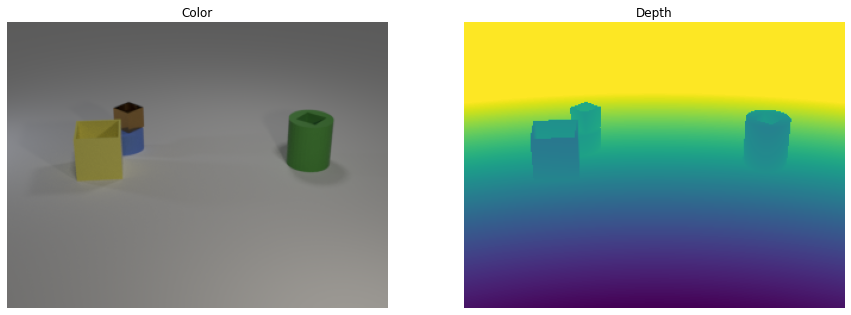

In [162]:
'''
Show RGB and depth images
'''
from matplotlib import pyplot as plt

# Show images
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 15)
# Add color image plot
ax[0].imshow(color_mat)
ax[0].set_title('Color')
ax[0].axis('off')
# Add depth image plot
ax[1].imshow(np.minimum(depth_mat, 20))
ax[1].set_title('Depth')
ax[1].axis('off')

'''
Analyze predicates stored in h5 file
'''

relations = ['front', 'right', 'contain', 'support']
rel_data = np.array(my_scene['relations'])
print(f'shape {rel_data.shape}')
# Check square array that matches number of objects
assert(len(objects) == rel_data.shape[1])
assert(rel_data.shape[1] == rel_data.shape[2])

for i, rel in enumerate(relations):
    print(rel.upper())
    for j in range(len(objects)):
        for k in range(len(objects)):
            if rel_data[i, j, k]:
                print(f'{objects[j]} {rel} {objects[k]}')


In [163]:
example_hf.close()
my_hf.close()